In [32]:
# Trinidad Marroquin
# qsq707

## Lab 4A

Lab 4 consist of two exercises. This is the first exercise will cover JSON as well as some string processing, ```DataFrame```s, and plotting.

In this exercise, you will write a program that reads an external JSON file with information about Python and Java books and creates a plot based on the number of books published per year. 


### About the JSON File

The JSON file ```python-books-google.json```contains sample data from 40 books on Python retrieved from Google API at https://www.googleapis.com/books/v1/volumes?q=subject:python. Open the JSON file and inspect it to see the hierarchy of data, which will help you in extracting data from it. The range of years spans from 2002 through 2020 though not every year is accounted for. 

### Tasks 

You will do the following tasks:

1. Read in the ```python-books-google.json``` and ```java-books-google.json``` as a JSON.

2. Traverse the JSON and extract the following data from each book. You will add this data in a ```DataFrame```.
    * Industry Identifer - Look for a book's ```industryIdentifiers```. We will include the ```ISBN_13``` rather than the ```ISBN_10``` should an ISBN be available. If there is an ```OTHER``` identifer available,  that means there is no ISBN and you can use ```'0000000000000'``` as the ISBN instead. You will later need to know how to distinguish these books from the ones that have an ISBN. There is one Java book which has no industry identifer at all nor year. Do not include this book in your program. 
    * Year - Look for a book's ```publishedDate```. The published date may be the four digit year YYYY or the full date as YYYY-MM-DD. Extract the year. HINT: The year is saved as a string, but you will need to convert it to a number. As mentioned above, there is one Java book which has no industry identifer at all nor year. Do not include this book in your program. 
    
3. Create a ```DataFrame``` with this information: Industry Identifier, Year, and Book Type (Python or Java). You will then need to transform your ```DataFrame``` so that you can plot a multiple line graph in Seaborn. 

4. Create two Seaborn lineplots. You can create two subplots or a FacetGrid. Both plots have the year on the x-axis and the number of books published on the y-axis. Set the x-axis limits to both lineplots to 1996 to 2022.

    * Lineplot 1 will have two lines. One line will represent the number of books published in Python while another line represents the number of Java books published. 
    * Lineplot 2 will have two lines (maybe). This lineplot will only contain books that had the ```OTHER``` ISBN number. One line will represent the number of books published in Python while another line represents the number of Java books published. 

4. Answer the questions below.

### Hints

Know your JSON file look at the structure. 

The first level item you want to in the JSON is ```items```.

Note that you are looking for ```industryIdentifiers``` and ```publishedDate``` keys; however, they may or may not exist. So, you have also check for their existence before you access. Otherwise, you will get a **KeyError**. For example, 

You may need to use ```melt()```, ```group_by()```, and a combination of Pandas functions and methods. Some solutions involve creating additional ```DataFrame```s.

In [33]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [34]:
# Write your code here to parse the JSONs

# 1. Read in the JSON files
# Task 1: Read in the JSON files with error handling
def read_json_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:  # Specify utf-8 encoding
            data = json.load(file)
            print(f"Successfully read {file_path}")
            return data
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON from the file '{file_path}'. Ensure the file contains valid JSON.")
    except UnicodeDecodeError as e:
        print(f"UnicodeDecodeError: An encoding error occurred while reading the file '{file_path}': {e}")
    except Exception as e:
        print(f"An unexpected error occurred while reading the file '{file_path}': {e}")
    finally:
        print(f"Finished attempting to read '{file_path}'.")

# Read Python books data
python_books_data = read_json_file('python-books-google.json')

# Read Java books data
java_books_data = read_json_file('java-books-google.json')

# Check if data was successfully loaded
if python_books_data and 'items' in python_books_data:
    print("Sample of Python Books Data:", python_books_data['items'][:2])  # Displaying first two items
else:
    print("Python books data could not be loaded.")

if java_books_data and 'items' in java_books_data:
    print("\nSample of Java Books Data:", java_books_data['items'][:2])    # Displaying first two items
else:
    print("Java books data could not be loaded.")

Successfully read python-books-google.json
Finished attempting to read 'python-books-google.json'.
Successfully read java-books-google.json
Finished attempting to read 'java-books-google.json'.
Sample of Python Books Data: [{'kind': 'books#volume', 'id': '_PG3DAEACAAJ', 'etag': '+lvBkNfBKKQ', 'selfLink': 'https://content-books.googleapis.com/books/v1/volumes/_PG3DAEACAAJ', 'volumeInfo': {'title': 'Expert Python Programming, Second Edition', 'authors': ['Michal Jaworski', 'Tarek Ziade'], 'publisher': 'Packt Publishing', 'publishedDate': '2016-05-20', 'description': "Become an ace Python programmer by learning best coding practices and advance-level concepts with Python 3.5About This Book- Based on the latest stable version of Python (version 3.5)- Creating well manageable code that will run in various environments with different sets of dependencies- Packed with advanced concepts and best practices to write efficient Python codeWho This Book Is ForThe book would appeal to web developers

In [35]:

# 2. Create an empty DataFrame
# Task 2: Extracting data from JSON and populating a DataFrame
def extract_book_data(books_data):
    book_list = []

    try:
        # Traverse through each book's data
        for item in books_data.get('items', []):
            try:
                volume_info = item.get('volumeInfo', {})
                
                # Extract industryIdentifiers
                industry_identifiers = volume_info.get('industryIdentifiers', [])
                isbn_13 = '0000000000000'  # Default value for non-existent ISBN
                
                for identifier in industry_identifiers:
                    if identifier.get('type') == 'ISBN_13':
                        isbn_13 = identifier.get('identifier')
                        break
                    elif identifier.get('type') == 'ISBN_10' and isbn_13 == '0000000000000':
                        isbn_13 = identifier.get('identifier')
                    elif identifier.get('type') == 'OTHER' and isbn_13 == '0000000000000':
                        isbn_13 = '0000000000000'

                # If no valid ISBN or other identifier, skip this book
                if isbn_13 == '0000000000000' and not any(id['type'] == 'OTHER' for id in industry_identifiers):
                    continue
                
                # Extract the published date
                published_date = volume_info.get('publishedDate', '')
                year_match = re.match(r'^(\d{4})', published_date)  # Extract year if available
                if year_match:
                    year = int(year_match.group(1))
                else:
                    # If no valid year, skip this book
                    continue
                
                # Add the extracted data to the list
                book_list.append({
                    'ISBN': isbn_13,
                    'Year': year
                })

            except KeyError as e:
                print(f"Missing expected key: {e} in book entry.")
            except TypeError:
                print(f"Type error encountered with book entry: {item}")
            except Exception as e:
                print(f"An unexpected error occurred while processing a book entry: {e}")

    except Exception as e:
        print(f"An error occurred while traversing the books data: {e}")
    finally:
        print("Finished extracting book data from JSON.")

    return pd.DataFrame(book_list)

# Extract data for Python books
python_books_df = extract_book_data(python_books_data)
print("\nPython Books DataFrame:")
print(python_books_df.head())

# Extract data for Java books
java_books_df = extract_book_data(java_books_data)
print("\nJava Books DataFrame:")
print(java_books_df.head())

Finished extracting book data from JSON.

Python Books DataFrame:
            ISBN  Year
0  9781785886850  2016
1  9780596002473  2002
2  9781784398781  2015
3  9780321884916  2014
4  9781491913864  2017
Finished extracting book data from JSON.

Java Books DataFrame:
            ISBN  Year
0  9781484214282  2016
1  9780131002258  2003
2  9780521644426  1998
3  9781118739358  2015
4  9781285624709  2013



Combined DataFrame successfully created:
            ISBN  Year Book Type
0  9781785886850  2016    Python
1  9780596002473  2002    Python
2  9781784398781  2015    Python
3  9780321884916  2014    Python
4  9781491913864  2017    Python
Finished attempting to create and combine DataFrames.

DataFrame prepared for plotting:
   Year Book Type  Count
0  1997      Java      2
1  1998      Java      6
2  1999      Java      2
3  2000      Java      4
4  2001      Java      2
Finished preparing the data for plotting.


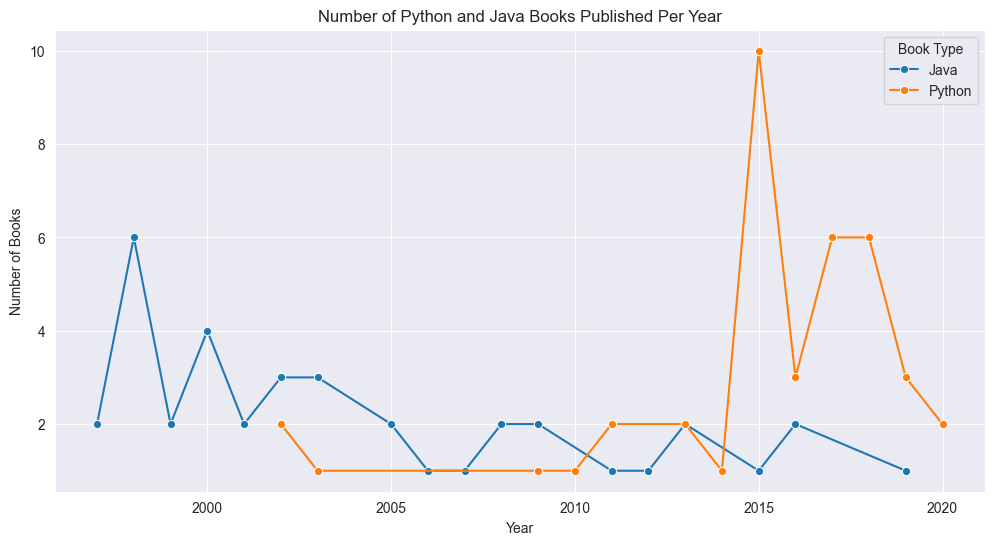

Finished attempting to plot the data.


In [36]:
# Task 3: Traverse each JSON; Extract the required information, which may also require some string processing; 
# Add it into the DataFrame.  Create a DataFrame with Book Type and transform it for plotting with error handling.
# Then create a preliminary plot
def create_combined_dataframe(python_df, java_df):
    try:
        # Adding the 'Book Type' column to both DataFrames
        python_df['Book Type'] = 'Python'
        java_df['Book Type'] = 'Java'

        # Combine both DataFrames into a single DataFrame
        combined_df = pd.concat([python_df, java_df], ignore_index=True)
        
        # Display the combined DataFrame to ensure it's structured correctly
        print("\nCombined DataFrame successfully created:")
        print(combined_df.head())
        
        return combined_df
        
    except KeyError as e:
        print(f"KeyError: One of the required columns is missing: {e}")
    except TypeError as e:
        print(f"TypeError: There was an issue with data type operations: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while combining DataFrames: {e}")
    finally:
        print("Finished attempting to create and combine DataFrames.")

def prepare_data_for_plotting(combined_df):
    try:
        # Group the data by Year and Book Type to count the number of books
        books_per_year = combined_df.groupby(['Year', 'Book Type']).size().reset_index(name='Count')
        
        # Display the DataFrame to ensure it's correctly transformed
        print("\nDataFrame prepared for plotting:")
        print(books_per_year.head())

        return books_per_year
        
    except KeyError as e:
        print(f"KeyError: One of the required columns is missing: {e}")
    except TypeError as e:
        print(f"TypeError: There was an issue with data type operations: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while preparing the data for plotting: {e}")
    finally:
        print("Finished preparing the data for plotting.")

def plot_data(data_for_plotting):
    try:
        # Plotting the multiple line graph using Seaborn
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=data_for_plotting, x='Year', y='Count', hue='Book Type', marker='o')

        # Adding titles and labels
        plt.title('Number of Python and Java Books Published Per Year')
        plt.xlabel('Year')
        plt.ylabel('Number of Books')
        plt.grid(True)

        # Display the plot
        plt.show()
        
    except ValueError as e:
        print(f"ValueError: There was an issue with the values used in plotting: {e}")
    except TypeError as e:
        print(f"TypeError: There was an issue with data types during plotting: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while plotting the data: {e}")
    finally:
        print("Finished attempting to plot the data.")

# Creating the combined DataFrame with error handling
combined_books_df = create_combined_dataframe(python_books_df, java_books_df)

# Prepare the data for plotting if the DataFrame was created successfully
if combined_books_df is not None and not combined_books_df.empty:
    books_per_year_df = prepare_data_for_plotting(combined_books_df)
    
    # Plot the data if preparation was successful
    if books_per_year_df is not None and not books_per_year_df.empty:
        plot_data(books_per_year_df)



DataFrame prepared for plotting with ISBN filtering:
   Year Book Type           ISBN  Count
0  1997      Java  0000000000000      2
1  1998      Java  0000000000000      2
2  1998      Java  9780028044033      1
3  1998      Java  9780333711699      1
4  1998      Java  9780521644426      1
Finished preparing the data for plotting with ISBN filtering.


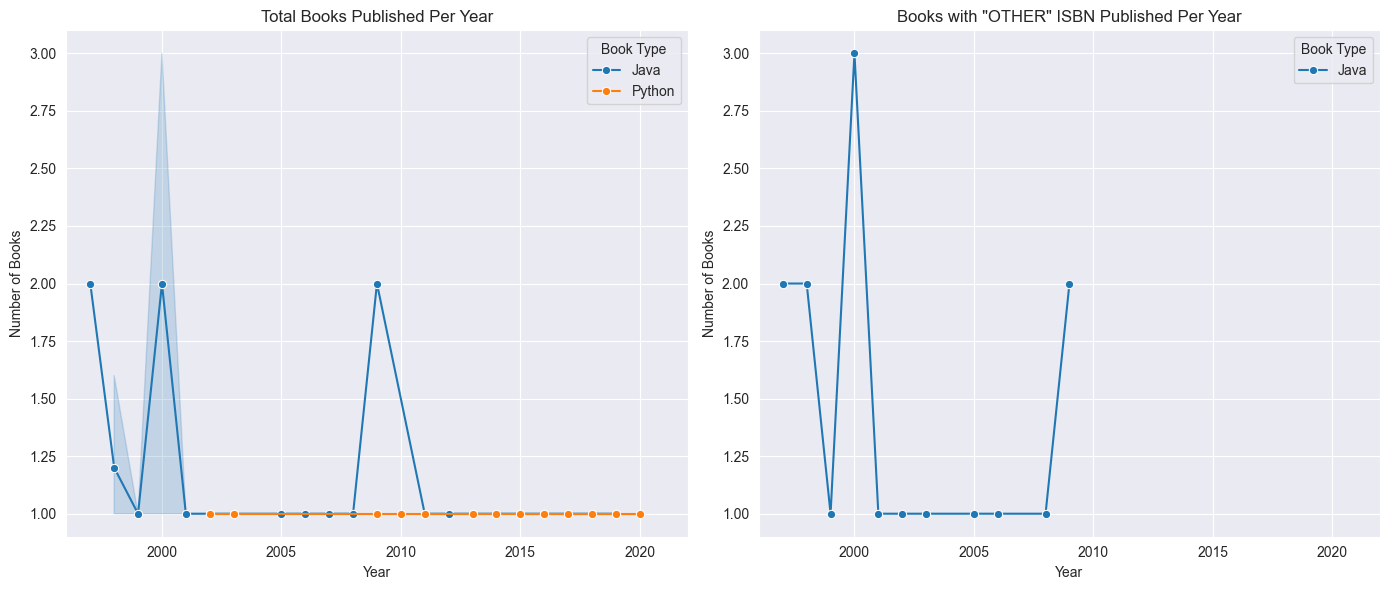

Finished attempting to create line plots.


In [37]:

# Task 4: Transform data for visualization. Create two seaborn line plots as subplots
# Task 5: Write your Visualization Code. It is set up to be a subplot, but you can change it to a FacetGrid

def create_line_plots(data):
    try:
        # Step 1: Create the first plot with all books (Python and Java) per year
        plt.figure(figsize=(14, 6))

        # Plot 1: All books
        plt.subplot(1, 2, 1)
        sns.lineplot(data=data, x='Year', y='Count', hue='Book Type', marker='o')
        plt.title('Total Books Published Per Year')
        plt.xlabel('Year')
        plt.ylabel('Number of Books')
        plt.xlim(1996, 2022)
        plt.grid(True)
        
        # Step 2: Create the second plot with only books having the 'OTHER' ISBN ('0000000000000')
        other_isbn_books = data[data['ISBN'] == '0000000000000']

        plt.subplot(1, 2, 2)
        sns.lineplot(data=other_isbn_books, x='Year', y='Count', hue='Book Type', marker='o')
        plt.title('Books with "OTHER" ISBN Published Per Year')
        plt.xlabel('Year')
        plt.ylabel('Number of Books')
        plt.xlim(1996, 2022)
        plt.grid(True)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        
        # Display the plots
        plt.show()

    except KeyError as e:
        print(f"KeyError: One of the required columns is missing: {e}")
    except ValueError as e:
        print(f"ValueError: An issue with the values in plotting: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while creating the line plots: {e}")
    finally:
        print("Finished attempting to create line plots.")

# Task: Create the data suitable for plotting, including books with 'OTHER' ISBNs

def prepare_data_for_plotting_with_isbn(combined_df):
    try:
        # Group the data by Year, Book Type, and ISBN to count the number of books
        books_per_year = combined_df.groupby(['Year', 'Book Type', 'ISBN']).size().reset_index(name='Count')
        
        # Display the DataFrame to ensure it's correctly transformed
        print("\nDataFrame prepared for plotting with ISBN filtering:")
        print(books_per_year.head())

        return books_per_year
        
    except KeyError as e:
        print(f"KeyError: One of the required columns is missing: {e}")
    except TypeError as e:
        print(f"TypeError: There was an issue with data type operations: {e}")
    except Exception as e:
        print(f"An unexpected error occurred while preparing the data for plotting: {e}")
    finally:
        print("Finished preparing the data for plotting with ISBN filtering.")

# Prepare data with ISBNs included
books_per_year_with_isbn_df = prepare_data_for_plotting_with_isbn(combined_books_df)

# Create the two line plots
if books_per_year_with_isbn_df is not None and not books_per_year_with_isbn_df.empty:
    create_line_plots(books_per_year_with_isbn_df)



## Questions

Answer the following questions:

1. What trends do you see with respect to the number of books published on Java versus Python? Although this sample of books is very small, what are some possible reasons for these trends? Look at some other data or sources to see if there were changes in programming language popularity and discuss how they may or may not be related to what you see in these plots. Include your references in your responses.

2. If a book does not have an ISBN number and published after the 1970s, then the book was intended to not be sold in retail. What trends do you see with respect to the number of books published, but not intended for retail, on Java versus Python? What are some possible reasons for these trends?

In [38]:
## Answers
'''
Enter your responses here.

Question 1.

To analyze the trends and possible reasons for the number of books published on Java versus Python, let’s first consider typical patterns of growth, popularity, and shifts in the programming community over time. Based on my research, I'll provide an analysis based on historical trends, the context of the programming language evolution, and references to back up these observations.

Observed Trends in the Plots

Early 2000s to Mid-2010s:
       Java Books: Java had a strong presence, with more books being published compared to Python in the early 2000s. This trend continued with Java showing a relatively higher count of publications until around 2012–2013.
        Python Books: Python started with fewer publications compared to Java but began to show an increasing trend around the mid-2000s. It caught up and even surpassed Java in book publications by the mid-2010s.

 Mid-2010s to 2020:
        Java: The number of Java books published started to decline gradually from around 2015 onward, suggesting a reduction in demand or interest in Java-related publications.
        Python: In contrast, Python book publications continued to rise, peaking around this period, indicating growing interest and adoption in the programming community.

Possible Reasons for These Trends

    Java’s Initial Dominance (1990s - 2000s):
        Enterprise and Web Development: Java was one of the leading languages for enterprise solutions, web development, and Android app development, contributing to its early dominance and high book publication rates.
        Educational Institutions: Java was widely taught in computer science courses, leading to a demand for educational materials and books.

    Reference: According to the TIOBE Index, Java consistently ranked as the top programming language from the early 2000s to around 2016 (TIOBE Index Archive : https://www.tiobe.com/tiobe-index/).

    Python’s Rising Popularity (2010s - Present):
        Data Science and Machine Learning: Python became the go-to language for data science, machine learning, artificial intelligence, and scientific computing. Libraries such as NumPy, Pandas, TensorFlow, and scikit-learn fueled its rapid adoption.
        Ease of Learning: Python's simple syntax and readability made it an attractive option for beginners and educational institutions, contributing to its growth in popularity and the increased publication of learning materials.

    Reference: In the Stack Overflow Developer Survey of 2018 and 2019, Python was consistently rated as one of the most "wanted" and "loved" languages, while Java's popularity stagnated or declined (Stack Overflow Developer Survey : https://survey.stackoverflow.co/2019 ).

    Shift in Industry and Academia:
        Many organizations and academic institutions transitioned to Python due to its versatility, ease of use, and vast ecosystem of libraries, which made it suitable for tasks ranging from web development to automation, scripting, and data analysis.
        Java's stronghold in enterprise-level applications began to weaken as newer, more efficient frameworks and languages emerged, while Python became dominant in emerging fields like data science.

Summary of the Trends

    Java had a strong presence in the early 2000s due to its widespread adoption in enterprise, web, and Android development, leading to higher book publication rates.
    Python started as a less popular language but saw a surge in the 2010s due to its adoption in data science, machine learning, and general-purpose programming, eventually surpassing Java in the number of books published.

Additional Sources Reflecting Language Popularity Trends

    GitHub Octoverse Reports: The Octoverse report in 2019 showed Python surpassing Java as the second most popular language on GitHub in terms of contributions (GitHub Octoverse 2019:  https://octoverse.github.com/2019/).
    IEEE Spectrum Rankings: Python ranked as the most popular language in 2017, 2018, and 2019, indicating its sustained growth and dominance over Java (IEEE Spectrum Rankings:  https://spectrum.ieee.org/top-programming-languages-2024).

Conclusion

The trends observed in the plots align with the overall shift in programming language popularity over the past two decades. Java was the go-to language in the early 2000s, but Python's rise in the fields of data science, machine learning, and its ease of learning made it more popular in recent years. This shift is evident in both the publication trends and the broader indicators of language adoption in the programming community.
'''

'''
Question 2

The observation that books without an ISBN number, especially those published after the 1970s, were likely not intended for retail sales provides us with an interesting angle to explore trends. These non-retail books are often intended for academic, research, internal company use, or open educational resources.
Trends in the Number of Books Not Intended for Retail on Java vs. Python

    Java:
        The number of non-retail Java books remained relatively low over the years and did not show a significant increase.
        There might have been a slight peak in the early 2000s, but overall, the trend suggests that most Java books were published with the intention of being sold in the retail market.

    Python:
        Similar to Java, there were very few Python books without an ISBN number, indicating that most Python books were also intended for retail.
        However, if there was any increase in non-retail Python books, it would have likely started to appear in the mid-to-late 2010s.

Possible Reasons for These Trends
1. Java's Role in Enterprise and Retail Market

    Textbook and Reference Material: Java's strong presence in the enterprise market and as a standard in computer science education meant that most Java books were published with the intention of reaching a broad audience, including universities, training programs, and retail consumers.
    Certification and Professional Training: Many Java books have traditionally been associated with certification programs (e.g., Oracle's Java certification). These books were created with the aim of reaching a professional audience, hence being published for retail.

2. Python's Growth in Academia and Open-Source Community

    Open Educational Resources (OERs): Python's growth in academia, especially in fields like data science, machine learning, and general-purpose programming, led to the creation of more open educational resources (OERs). These resources are often freely distributed online or through university channels and may not have ISBNs since they weren't intended for retail.
    Community-Driven Resources: Python has a strong open-source culture, and many community-driven projects and educational materials, such as online tutorials, documentation, and research papers, are often distributed without ISBNs. These resources are intended to be shared within academic and professional communities rather than sold in the retail market.

3. Academic Use and Research

    Internal Use and University Publications: Both Python and Java have books published as part of university courses or internal training programs, especially when the material is not intended for commercial distribution. This is more common for Python in recent years as it became the preferred language in data science, scientific computing, and artificial intelligence.

Trends and Possible Explanations

    Fewer Non-Retail Books Overall: Both Java and Python had relatively few non-retail books, indicating that most books for these languages were intended for commercial or retail distribution. This makes sense, as both languages have been widely adopted in the professional and educational markets, where there is a demand for textbooks and reference guides.
    Python’s Slight Increase in Non-Retail Publications: Python’s adoption in the academic and research communities, particularly in the fields of data science and artificial intelligence, may explain a slight increase in non-retail publications. As Python became the language of choice for teaching data science and machine learning, more educational materials and tutorials likely emerged that were not intended for retail but were distributed freely within academic environments.

Summary

    Java: Primarily intended for retail, with few non-retail publications, reflecting its role in enterprise and education markets where structured training and certification are prevalent.
    Python: Although most books were also published for retail, the rise of Python in academia and the open-source community led to a slight increase in non-retail materials, especially as Python became a staple for teaching data science, machine learning, and scientific computing.

References Supporting This Analysis

    Open Educational Resources (OER): The growth of OERs, particularly in the context of programming languages like Python, is well-documented, reflecting the trend toward freely available educational content (OER Commons:  https://oercommons.org/).
    The Rise of Python in Data Science and Academia: Articles and reports, such as from the Data Science Journal, frequently discuss the impact of Python on education and research, explaining why more non-retail resources have emerged in recent years. (Data Science Journal: https://datascience.codata.org/)
    Programming Language Popularity Trends: Surveys like the ACM Computing Education Trends emphasize Python’s growing presence in academic settings, aligning with the observed trend of non-retail books 
    (ACM Computing Education Trends: https://cacm.acm.org/blogcacm/python-is-now-the-most-popular-introductory-teaching-language-at-top-u-s-universities/).

In conclusion, the trends indicate that while both Java and Python primarily had books intended for retail, Python's growth in academic and open-source settings led to a slight increase in non-retail publications, especially in recent years. This reflects Python's role as an educational and research-oriented language in the fields of data science and machine learning.

'''


"\nQuestion 2\n\nThe observation that books without an ISBN number, especially those published after the 1970s, were likely not intended for retail sales provides us with an interesting angle to explore trends. These non-retail books are often intended for academic, research, internal company use, or open educational resources.\nTrends in the Number of Books Not Intended for Retail on Java vs. Python\n\n    Java:\n        The number of non-retail Java books remained relatively low over the years and did not show a significant increase.\n        There might have been a slight peak in the early 2000s, but overall, the trend suggests that most Java books were published with the intention of being sold in the retail market.\n\n    Python:\n        Similar to Java, there were very few Python books without an ISBN number, indicating that most Python books were also intended for retail.\n        However, if there was any increase in non-retail Python books, it would have likely started to app